In [1]:
#from dask.distributed import LocalCluster
#cluster = LocalCluster()          # Fully-featured local Dask cluster

In [2]:
#from dask.distributed import LocalCluster
#cluster = LocalCluster()          # Fully-featured local Dask cluster

In [3]:
%load_ext memory_profiler

In [4]:
base_grid_kwargs = {
    "size_x": 1080, 
    "size_y": 1080, 
    "center_lon": -20, 
    "center_lat": 65, 
    "rot": 0, 
    "topography_source": {
        "name": "SRTM15",
        "path": "/glade/derecho/scratch/noraloose/Datasets/SRTM15/SRTM15_V2.6.nc",
    }
}

In [5]:
grids = {
    "A": {"nx": 1000, "ny": 1000, "N": 100, **base_grid_kwargs},
    "B": {"nx": 2000, "ny": 2000, "N": 100, **base_grid_kwargs},  
    "C": {"nx": 2000, "ny": 2000, "N": 500, **base_grid_kwargs},   
}

# Performance

In [6]:
key = "A"

In [21]:
use_dask = True
bypass_validation = False

In [8]:
from roms_tools import Grid

We first create our grid object.

In [9]:
grid = Grid(**grids[key])

In [25]:
path = "/glade/derecho/scratch/noraloose/Datasets/ERA5/NA/2012/ERA5*.nc"
#path = "/glade/derecho/scratch/noraloose/Datasets/ERA5/NA/2012/ERA5_2012-01.nc"
#path = "/glade/derecho/scratch/noraloose/Datasets/ERA5/NA/2012/ERA5_2012-01-02.nc"

In [26]:
from roms_tools import SurfaceForcing

In [27]:
from datetime import datetime

In [28]:
start_time = datetime(2012, 1, 1)
end_time = datetime(2012, 12, 31)

In [29]:
%%time
%%memit

surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": path},
    type="physics",
    correct_radiation=True,
    use_dask=use_dask,
    coarse_grid_mode="never",
    bypass_validation=bypass_validation
)

INFO - Data will be interpolated onto fine grid.


peak memory: 37703.91 MiB, increment: 1410.77 MiB
CPU times: user 1min 53s, sys: 1.67 s, total: 1min 55s
Wall time: 1min 58s


In [30]:
surface_forcing.ds

<xarray.Dataset> Size: 246GB
Dimensions:   (time: 8761, eta_rho: 1002, xi_rho: 1002)
Coordinates:
    abs_time  (time) datetime64[ns] 70kB 2012-01-01 ... 2012-12-31
  * time      (time) float64 70kB 4.383e+03 4.383e+03 ... 4.748e+03 4.748e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    swrad     (time, eta_rho, xi_rho) float32 35GB dask.array<chunksize=(1, 1002, 1002), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 35GB dask.array<chunksize=(1, 1002, 1002), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 35GB dask.array<chunksize=(1, 1002, 1002), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 35GB dask.array<chunksize=(1, 1002, 1002), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 35GB dask.array<chunksize=(1, 1002, 1002), meta=np.ndarray>
    uwnd      (time, eta_rho, xi_rho) float32 35GB dask.array<chunksize=(1, 1002, 1002), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 35GB dask.array<chunksize=(1, 1002, 1002), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev165
    start_time:            2012-01-01 00:00:00
    end_time:              2012-12-31 00:00:00
    source:                ERA5
    correct_radiation:     True
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

In [31]:
print(f"Memory footprint: {surface_forcing.ds.nbytes / 1e6:.2f} MB")

Memory footprint: 246290.35 MB


To see the values of the tidal forcing variables we can examine the `xarray.Dataset` object returned by the `.ds` property.

We can also plot any of the tidal forcing fields via the `.plot` method.

peak memory: 39006.58 MiB, increment: 7.20 MiB
CPU times: user 607 ms, sys: 281 ms, total: 888 ms
Wall time: 3.74 s


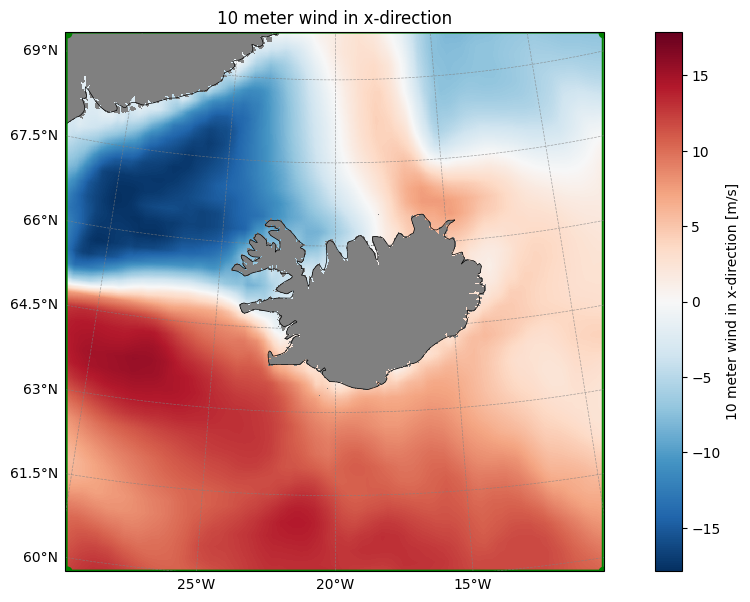

In [17]:
%%time
%%memit

surface_forcing.plot("uwnd")

## Saving as NetCDF or YAML file

Finally, we can save our tidal forcing as a netCDF file via the `.save` method.

In [18]:
filepath = "/glade/derecho/scratch/noraloose/forcing/my_surface_forcing.nc"

In [19]:
%%time
%%memit

surface_forcing.save(filepath, group=True)

peak memory: 112798.23 MiB, increment: 73759.67 MiB
CPU times: user 1min 54s, sys: 41.7 s, total: 2min 36s
Wall time: 2min 44s
